In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, spearmanr
import statsmodels.api as sm
import numpy as np

In [2]:
# הכנת הנתונים
df = pd.read_csv("Default of Credit Card Clients.csv", header=0)
df.columns = df.columns.str.strip()

gender_map = {1: "Male", 2: "Female"}
marriage_map = {1: 'Married', 2: 'Single', 3: 'Other'}
education_map = {
    0: 'Other',
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Other',
    5: 'Other',
    6: 'Other'
}

TEST 1 - בדיקת השפעת מגדר על אי חדלות פירעון

Chi-square Test: 47.709, p-value: 4.9447e-12


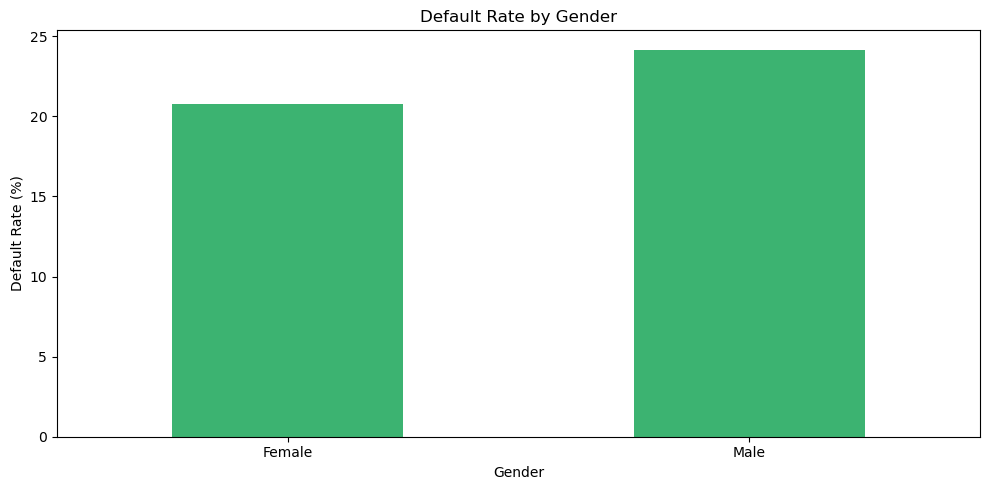

In [3]:
df["Gender"] = df["SEX"].map(gender_map)
df["Default_Status"] = df["dpnm"].map({0: "No Default", 1: "Default"})

contingency = pd.crosstab(df["Gender"], df["Default_Status"])

# מבחן Chi-square
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square Test: {chi2:.3f}, p-value: {p:.4e}")

# שיעור אי חדלות פירעון לפי מגדר
default_rates = df.groupby("Gender")["dpnm"].mean().reset_index()
default_rates.columns = ["Gender", "Default Rate"]

# תצוגה גרפית
default_rates = contingency.apply(lambda row: row["Default"] / row.sum(), axis=1) * 100
plt.figure(figsize=(10, 5))
default_rates.sort_values().plot(kind='bar', color='mediumseagreen')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

TEST 2 - שילוב מגדר ומצב משפחתי על שיעור אי חדלות פירעון

Chi-Square Test: = 81.881, p-value = 3.3897e-16


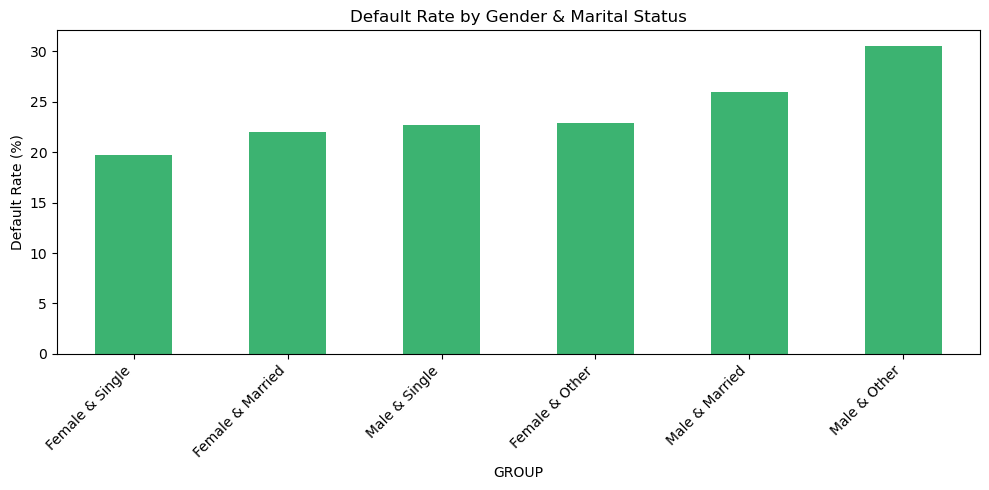

In [4]:
df['GROUP'] = df['SEX'].map(gender_map) + ' & ' + df['MARRIAGE'].map(marriage_map)

contingency = pd.crosstab(df['GROUP'], df['dpnm'])

# מבחן Chi-square
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-Square Test: = {chi2:.3f}, p-value = {p:.4e}")

# תצוגה גרפית
default_rates = contingency.apply(lambda row: row[1] / row.sum(), axis=1) * 100
plt.figure(figsize=(10, 5))
default_rates.sort_values().plot(kind='bar', color='mediumseagreen')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Gender & Marital Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TEST 3 - השפעת גיל על שיעור אי חדלות פירעון

Chi-Square Test: = 46.165, p-value = 2.2753e-09


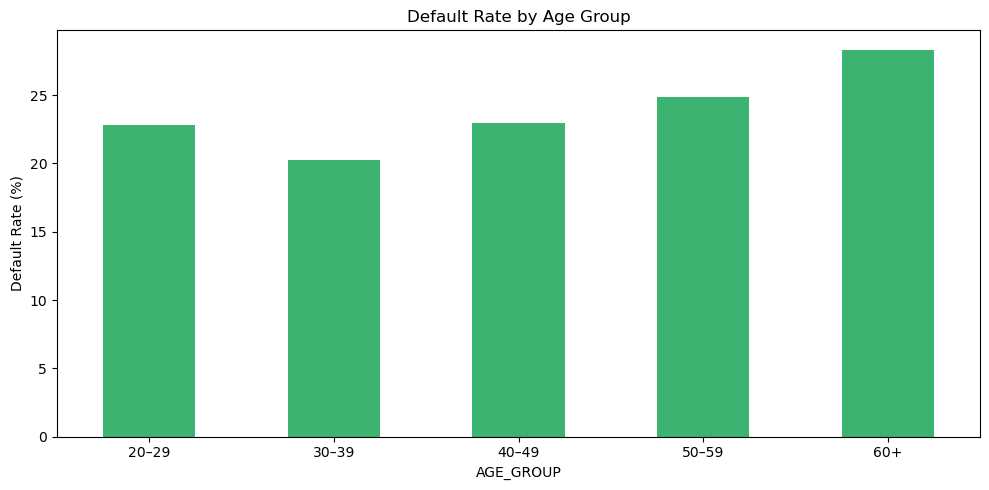

In [5]:
# יצירת קבוצות גיל
bins = [20, 30, 40, 50, 60, 100]
labels = ['20–29', '30–39', '40–49', '50–59', '60+']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

age_table = pd.crosstab(df['AGE_GROUP'], df['dpnm'])

# מבחן Chi-square
chi2, p, _, _ = chi2_contingency(age_table)
print(f"Chi-Square Test: = {chi2:.3f}, p-value = {p:.4e}")

# תצוגה גרפית
default_rates = age_table.apply(lambda row: row[1] / row.sum(), axis=1) * 100
plt.figure(figsize=(10, 5))
default_rates.plot(kind='bar', color='mediumseagreen')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

TEST 4 - השפעת השכלה על אי חדלות פירעון

Chi-Square Test: = 160.410, p-value = 1.4951e-34


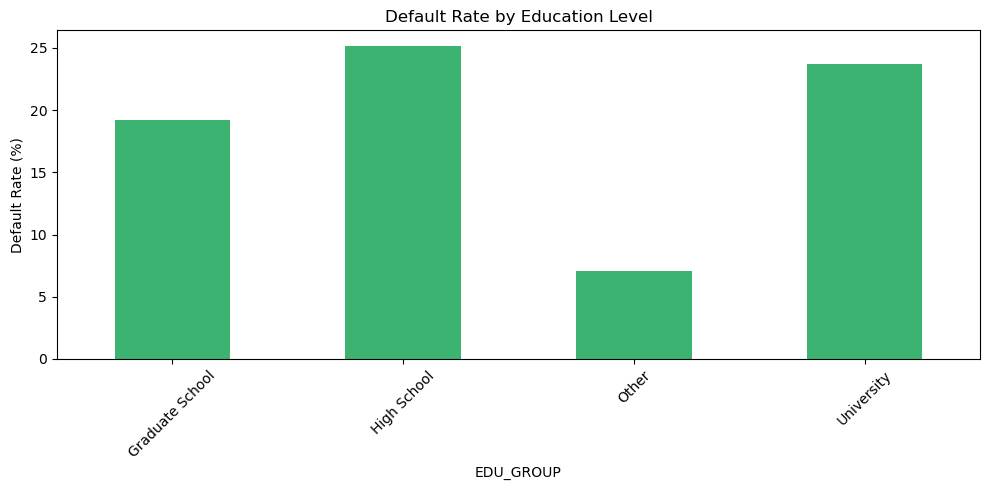

In [6]:
df['EDU_GROUP'] = df['EDUCATION'].map(education_map)

edu_table = pd.crosstab(df['EDU_GROUP'], df['dpnm'])

# מבחן Chi-square
chi2, p, _, _ = chi2_contingency(edu_table)
print(f"Chi-Square Test: = {chi2:.3f}, p-value = {p:.4e}")

# תצוגה גרפית
default_rates = edu_table.apply(lambda row: row[1] / row.sum(), axis=1) * 100
plt.figure(figsize=(10, 5))
default_rates.plot(kind='bar', color='mediumseagreen')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TEST 5 - הרחבת בדיקה ע"פ רגרסיה לוגיסטית

הקדמה - מטריצת קורולציה

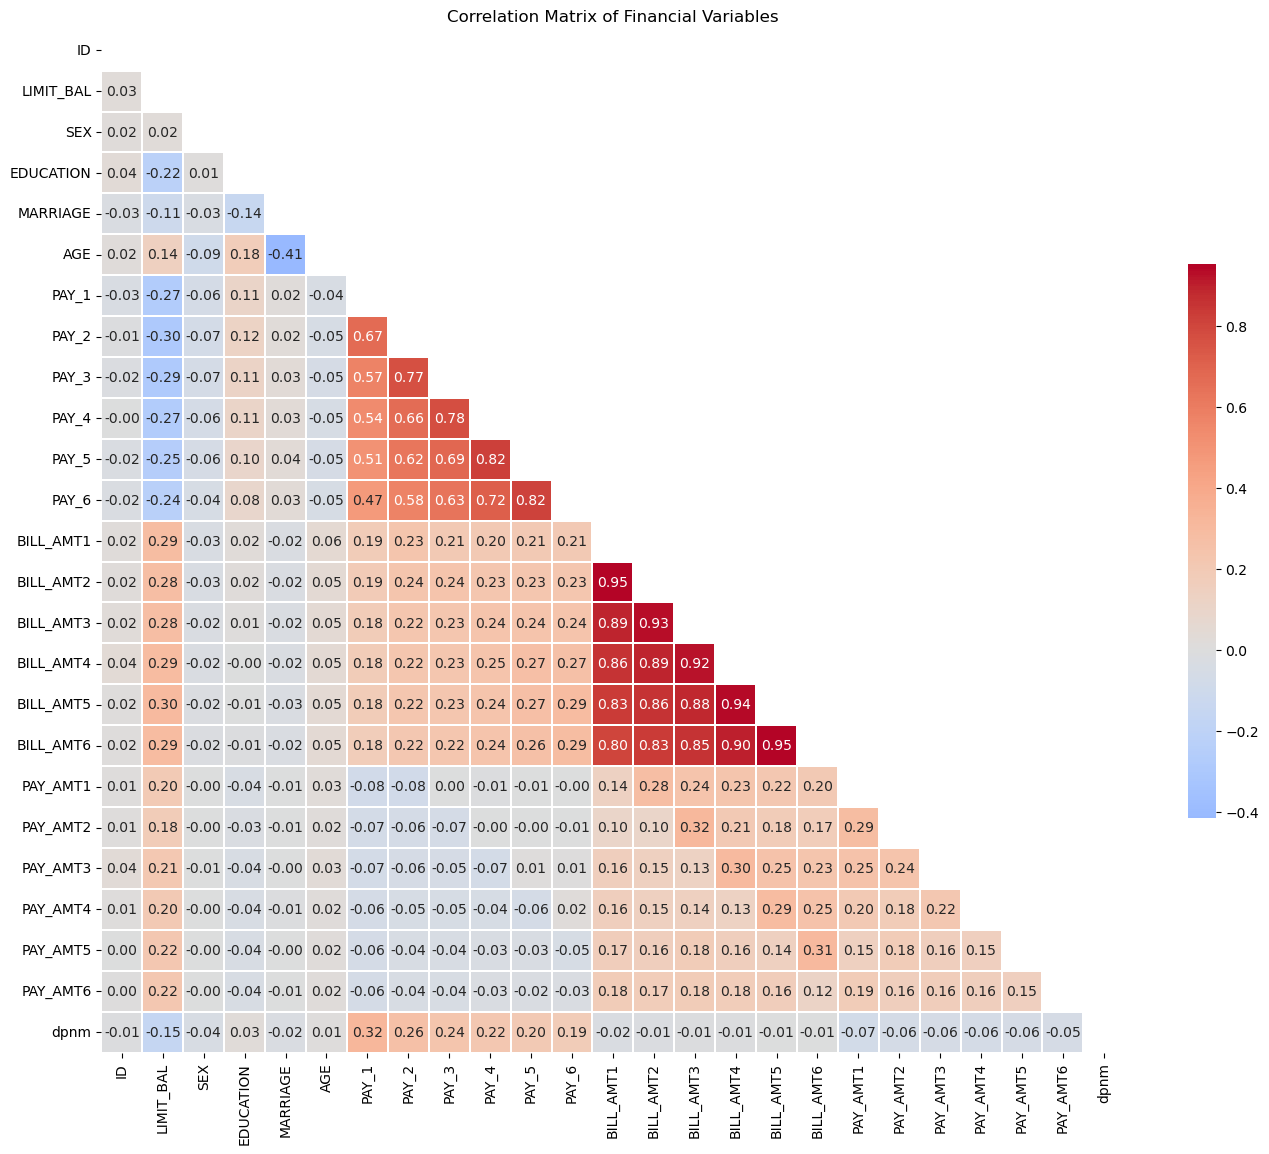

In [7]:
df['Gender'] = df['SEX'].map(gender_map)
df['Education'] = df['EDUCATION'].map(education_map)
df['Marriage'] = df['MARRIAGE'].map(marriage_map)

# יצירת מטריצת קורולציה
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# תצוגה גרפית
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.3, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix of Financial Variables")
plt.tight_layout()
plt.show()

רגרסיה לוגיסטית

Optimization terminated successfully.
         Current function value: 0.469192
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   dpnm   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29990
Method:                           MLE   Df Model:                            9
Date:                Sat, 26 Jul 2025   Pseudo R-squ.:                  0.1121
Time:                        11:28:18   Log-Likelihood:                -14076.
converged:                       True   LL-Null:                       -15853.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.0519      0.100    -10.523      0.000      -1.248      -0.

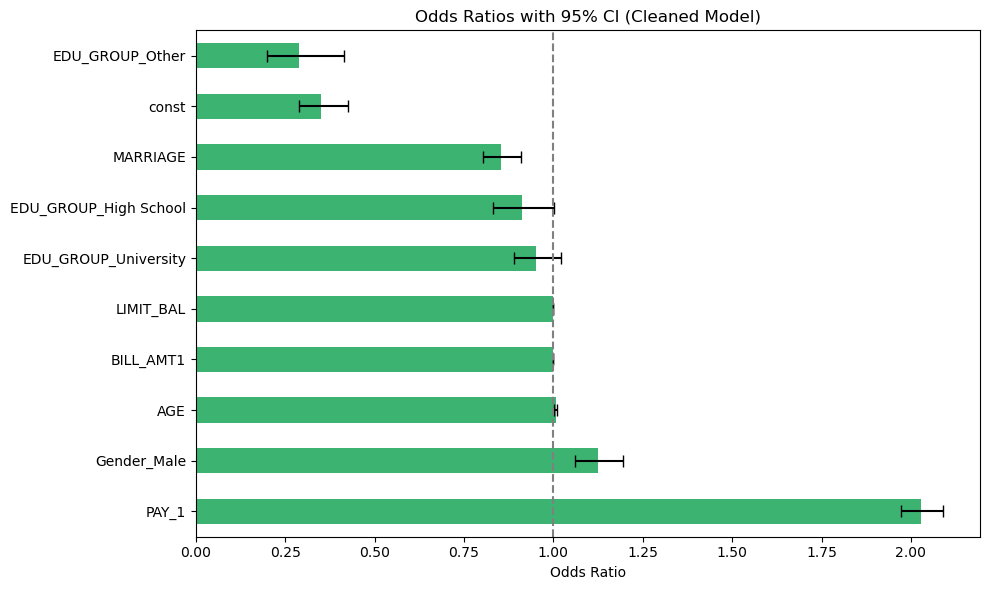

In [8]:
# בחירת משתנים
X = df[['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'Gender', 'EDU_GROUP', 'MARRIAGE']]
y = df['dpnm'].astype(int)

X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)

# הרצת מודל רגרסיה לוגיסטית
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

# Odds Ratio
odds_ratios = np.exp(result.params)
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']
conf_exp = np.exp(conf)
summary_table = pd.concat([odds_ratios, conf_exp], axis=1)
summary_table.columns = ['Odds Ratio', 'CI Lower', 'CI Upper']
summary_table = summary_table.sort_values(by='Odds Ratio', ascending=False)

# תצוגה גרפית
plt.figure(figsize=(10, 6))
summary_table['Odds Ratio'].plot(kind='barh', xerr=[
    summary_table['Odds Ratio'] - summary_table['CI Lower'],
    summary_table['CI Upper'] - summary_table['Odds Ratio']
], color='mediumseagreen', capsize=4)
plt.axvline(1, linestyle='--', color='gray')
plt.title("Odds Ratios with 95% CI (Cleaned Model)")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()


יצירת עץ החלטה

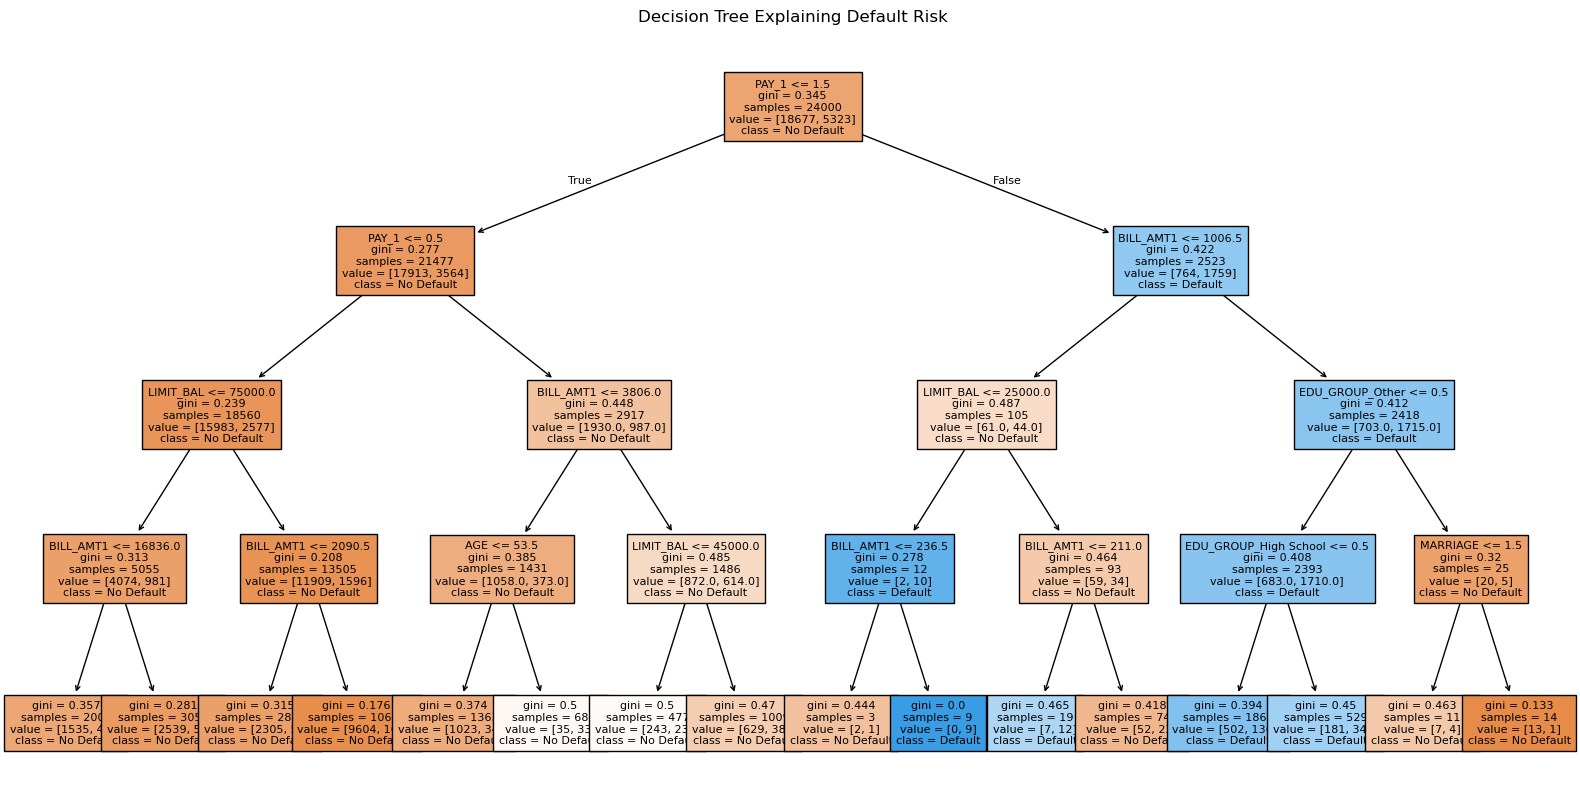

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

X = df[['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'Gender', 'EDU_GROUP', 'MARRIAGE']]
X = pd.get_dummies(X, drop_first=True)

y = df['dpnm']
y = pd.get_dummies(y, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# בניית עץ החלטה
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=['No Default', 'Default'], filled=True, fontsize=8)
plt.title("Decision Tree Explaining Default Risk")
plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()
